In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D

import pickle
from scipy import stats

In [2]:
data = dict()

files = ['PCECC96', 'WILL5000INDFC','GDPDEF','TB3MS']

for i in files:
    data[i] = pd.read_csv(i+'.csv')
    data[i]['DATE'] = pd.to_datetime(data[i]['DATE'])
    data[i] = data[i].set_index('DATE')

[data[i][i] for i in files]
dfrm = pd.concat([data[i][i] for i in files], axis=1, join='inner')
dfrm = dfrm.reset_index()

dfrm.columns = ['date', 'Ct', 'PMt', 'GDPDef', 'rfn']

for i in ['Ct', 'PMt', 'GDPDef', 'rfn' ]: #, 'qt','year'
    dfrm[i] = pd.to_numeric(dfrm[i])

#Set Inflation Rate, Rf real return on quarterly basis, Market real return net
dfrm['Infl'] = dfrm.GDPDef.pct_change()
dfrm['rfqr'] = dfrm.rfn/(4*100) - dfrm.Infl
dfrm['Rt'] = dfrm.PMt.pct_change() - dfrm.Infl + 1
dfrm['mt'] = .99* (dfrm.Ct.pct_change()+1)**(-6)

# Set time components (just informative)
dfrm['qt'] = dfrm['date'].dt.quarter
dfrm['year'] = dfrm['date'].dt.year


,date,Ct,PMt,GDPDef,rfn,Infl,rfqr,Rt,mt,qt,year
188,2018-04-01,12909.192,126.711094,110.281,1.840000,0.008468,-0.003868,0.990641,0.933292,2,2018
189,2018-07-01,13019.802,134.328571,110.767,2.040000,0.004407,0.000693,1.055710,0.940596,3,2018
190,2018-10-01,13066.302,126.443492,111.256,2.316667,0.004415,0.001377,0.936885,0.969048,4,2018
191,2019-01-01,13103.317,128.690492,111.473,2.386667,0.001950,0.004016,1.015820,0.973338,1,2019
192,2019-04-01,13241.083,136.506508,112.164,2.300000,0.006199,-0.000449,1.054536,0.929783,2,2019


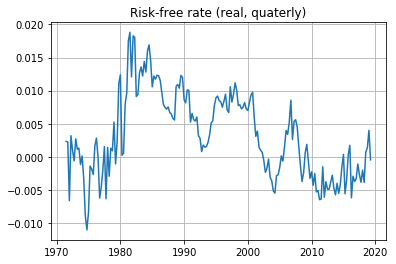

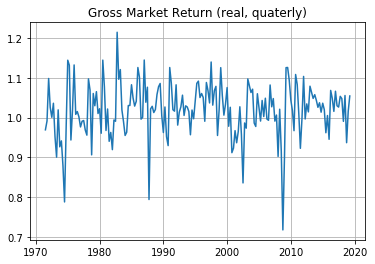

In [3]:
plt.figure()
plt.plot(dfrm.date, dfrm.rfqr)
plt.grid()
plt.title('Risk-free rate (real, quaterly)')
plt.figure()
plt.plot(dfrm.date, dfrm.Rt)
plt.grid()
plt.title('Gross Market Return (real, quaterly)')
dfrm.tail()

In [13]:
rf = dfrm.rfqr.tail(1)
print(rf *100)

192   -0.044881
Name: rfqr, dtype: float64


In [42]:
def capm_mkt(gamma,params):
    #unpack 
    dfrm, beta = params
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    covRtmt = np.cov(Rt,mt)[0,1]
    EtRt = np.mean(Rt)
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap = covRtmt + EtRt*Etmt - 1
    return ap

def capm_rf(gamma,params):
    #unpack 
    dfrm, beta = params
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    #set the real r.f. interest rate to the average over the observed period
    rf = np.mean(dfrm.rfqr.dropna())
    mt = dfrm.mt.dropna()
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap = 1/Etmt - 1 - rf
    return ap

def capm(unknowns,dfrm):
    ap = np.zeros(2)
    #unpack
    (gamma, beta) = unknowns
    # get the S.D.F.
    temp = dfrm.Ct.pct_change()+1
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    rf = np.mean(dfrm.rfqr.dropna())
    
    covRtmt = np.cov(Rt,mt)[0,1]
    EtRt = np.mean(Rt)
    Etmt = np.mean(mt)
    # get the asset pricing equation
    ap[0] = covRtmt + EtRt*Etmt - 1
    ap[1] = 1/Etmt - 1 - rf
   
    return ap

def capm_gmm(theta,W,dfrm):
    # GMM estimation of gamma and beta from the intertemporal asset pricing model. Hansen, Singleton style 
    g = np.zeros(2)
    #unpack
    (gamma, beta) = theta
    # get the S.D.F.
    dfrm['mt'] = beta* (dfrm.Ct.pct_change()+1)**(-gamma)
    mt = dfrm.mt.dropna()
    Rt = dfrm.Rt.dropna()
    #rf = np.mean(dfrm.rfqr.dropna())

    g[0] = np.mean( beta* mt*(Rt) -1 )
    g[1] = np.mean( beta* mt *(1+ dfrm.rfqr) -1)
    
    # the "error" 
    Q = g.reshape(1, len(g))@W@g.reshape(len(g),1)
    
    return float(Q)

### 2.5.1 Calculate the sample analogs of the expected values and covariance in (5)

In [18]:
# 2.5.1

gamma_guess = 10.
# pack params
beta = .99
params = dfrm, beta

Fn = lambda gamma: capm_mkt(gamma,params)
root = opt.root(Fn, gamma_guess, tol=.00001)
print(root)
print('gamma =',root.x)



    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.47532431e-10])
       r: array([0.0075184])
  status: 1
 success: True
       x: array([1.17571888])
gamma = [1.17571888]


### 2.5.2. How would you determine if this parameter is reasonable?

It seems too high, usually based on empirical investication of the risk preferences, we have gamma between 1 and 6. 10 is too high $\implies$ **the equity premium puzzle** 

### 2.5.3. Consider the moment restriction given in equation (7)


In [19]:
# 2.5.3
beta = .99
gamma_guess = 10

Fn = lambda gamma: capm_rf(gamma,params)
root = opt.broyden1(Fn, gamma_guess)
print(root)
print('gamma =',root)


-0.9169230585370297
gamma = -0.9169230585370297


Much lower estimate. $\implies$ Equity premium puzzle

### 2.5.4. Finally, estimate 𝛽 and 𝛾 using both equation (5) and equation (7).

In [66]:
# GMM
W = np.eye(2)
theta_guess = [10, 0.5]
Fn = lambda theta: capm_gmm(theta,W,dfrm)
# constraint beta < 1 
theta_0 = opt.minimize(Fn, x0=(theta_guess))
print(f'gamma = {theta_0.x[0]:.6}')
print(f'beta = {theta_0.x[1]:.6f}')

gamma = 9.99802
beta = 1.031357


$\implies$ The discount factor $\beta$ above 1 is unrealistic and the risk aversion factor $\gamma$ is rather high. Could be the result of negative interest rates and the equity premium puzzle.  
 

Text(0.5, 0, 'Asset Pricing Fn')

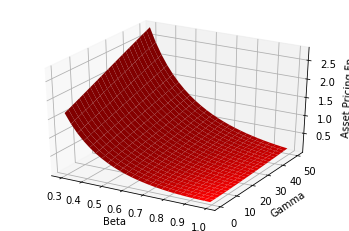

In [18]:
gridPoints = 25
beta_grid = np.linspace(.3,.99,gridPoints)
gamma_grid= np.linspace(.3,50,gridPoints)
ap = np.zeros([gridPoints,gridPoints])

for iG, gamma in enumerate(gamma_grid):
    for iB, beta in enumerate(beta_grid):
        unknowns = [gamma,beta]
        ap[iG,iB] = sum(capm(unknowns,dfrm))
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Bax, Gax = np.meshgrid(beta_grid,gamma_grid)
ax.plot_surface(Bax, Gax, ap, color='r')
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
ax.set_zlabel('Asset Pricing Fn')



## Problem 3.5 : The Kyle Model

+ First unpicle and process the data: 

In [2]:
files = ("C","AAPL","GBX","SPY","THO") # 
df = pd.DataFrame(columns=['Time','Price','Quantity','Side','drop1','drop2','Stock','Outlier'])
df.head()

for iF, file in enumerate(files):
    print('Loading file '+str(file))
    temp = pd.read_pickle(str(file))
    for jL in range(len(temp)):
        df2 = pd.DataFrame(temp[jL][1]).T
        df2 = df2.reset_index()
        df2.columns = ['Price','Quantity','Side','drop1','drop2']    
        df2['Stock'] = file
        df2['Time'] = temp[jL][0]
        # THE OUTLIER FILTER SEEMS TO BE WRONG, MUST BE THE MEDIAN CALC. DON'T USE IT
        # label quantities with more than 10 pc away from median
        m = df2.Price.median()
        df2['Outlier'] = (df2.Price > 1.1*m) | (df2.Price < .9*m)   
        df = pd.concat([df, df2], ignore_index=True,sort=True)

# drop redundant columns
df = df.drop(['drop1','drop2'], axis=1)
# re-define quantity from object as float
df.Quantity = df.Quantity.astype(np.float64)
# Define Buy with negative price
I = df.Side =="B"
df['PriceSide'] = (-1*I + (1-I))*df.Price
df.tail()


Loading file C
Loading file AAPL
Loading file GBX
Loading file SPY
Loading file THO


,Outlier,Price,Quantity,Side,Stock,Time,Price*Side
2232682,True,83.81,0.0,B,THO,57600,-83.81
2232683,False,103.60,1240.0,S,THO,57600,103.60
2232684,False,102.03,3713.0,B,THO,57600,-102.03
2232685,False,100.97,300.0,B,THO,57600,-100.97
2232686,False,103.53,132.0,S,THO,57600,103.53


## 3.5.1

In [15]:
# pick one of the time stamps and group 
stocksSide = df[df.Time == 57600].groupby(["Stock","Side"])
stocks = df[df.Time == 57600].groupby("Stock")
list(stocks.groups)


['AAPL', 'C', 'GBX', 'SPY', 'THO']

<Figure size 72x72 with 0 Axes>

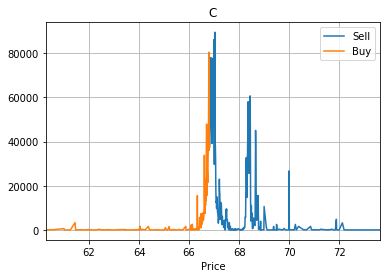

<Figure size 72x72 with 0 Axes>

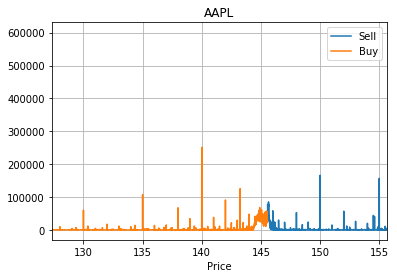

<Figure size 72x72 with 0 Axes>

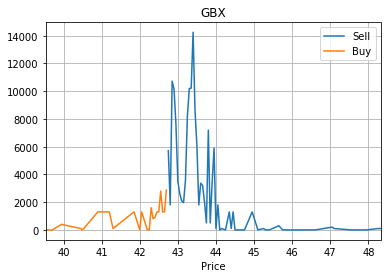

<Figure size 72x72 with 0 Axes>

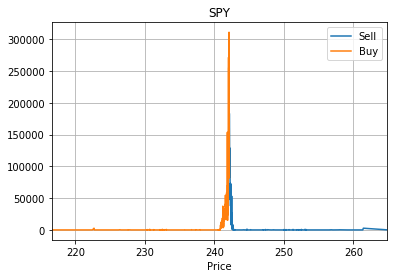

<Figure size 72x72 with 0 Axes>

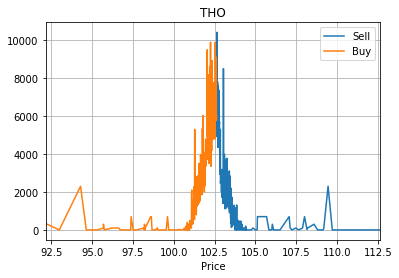

In [26]:
#Plot the order book

for iS, stock in enumerate(files):
    #get the median and plot only prices around the median
    med = stocks.get_group(stock).median()[1]
    plt.figure(figsize=(1,1))    
    ax1 = stocksSide.get_group((stock,"S")).sort_values(by=['Price']).plot(y='Quantity',x="Price",title=stock, label ='Sell' )
    ax1 = stocksSide.get_group((stock,"B")).sort_values(by=['Price']).plot(x="Price", y='Quantity',title=stock,label='Buy', ax=ax1)
    ax1.set_xlim(med*.9, med*1.1)
    ax1.grid()

In [44]:
# Estimate beta, gamma from eq. 10 

for iS, stock in enumerate(files):
    #estimate parameters on all prices
    X = df[(df.Stock==stock)]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.PriceSide,X.Quantity)
    print('------- ',str(stock)+' , Using all prices: \n')
    print(f'beta (slope) ={slope:.4f}') 
    print(f'gamma (intercept) ={intercept:.4f}')
    print(f'p-value ={p_value:.4f}')     
    print(f'R-Squared ={r_value**2:.4f} \n') 

    #estimate parameters only on non-outlier prices
    #X = df[(df.Stock==stock)&(df.Outlier==False)]
    # print(X[X.Outlier==True])
    #slope, intercept, r_value, p_value, std_err = stats.linregress(X.PriceSide,X.Quantity)
    
    #print('Prices 10pc around the median: \n')
    #print(f'beta (slope) ={slope: .4f}') 
    #print(f'p-value ={p_value: .4f}') 
    #print(f'R-Squared ={r_value**2:.4f} \n') 

#plt.ylim(60, 150)

-------  C , Using all prices: 

beta (slope) =-0.0256
gamma (intercept) =5321.8147
p-value =0.0000
R-Squared =0.0006 

-------  AAPL , Using all prices: 

beta (slope) =-0.0105
gamma (intercept) =1688.0724
p-value =0.0000
R-Squared =0.0000 

-------  GBX , Using all prices: 

beta (slope) =-0.1308
gamma (intercept) =1370.5045
p-value =0.6461
R-Squared =0.0000 

-------  SPY , Using all prices: 

beta (slope) =-0.0335
gamma (intercept) =7110.8395
p-value =0.0000
R-Squared =0.0001 

-------  THO , Using all prices: 

beta (slope) =-0.0054
gamma (intercept) =1161.5377
p-value =0.0000
R-Squared =0.0015 



+ The model fits better when we drop the orders which are far out of the money 

## Part 2

In [45]:
# Estimate beta, gamma from eq. 10 
Tlength = 390
noise = np.zeros([5,np.max(Tlength)])
p_zero = np.zeros([5,np.max(Tlength)])
TimeStamp = np.zeros(Tlength)


for iS, stock in enumerate(files):
    Timegrp = df.groupby(["Time"])
    TimeStamp = list(Timegrp.groups)

    for iT in range(Tlength):
        # estimate parameters only on non-outlier prices #&(df.Outlier==False)
        X = df[(df.Stock==stock)&(df.Time == TimeStamp[iT] )]
        slope, intercept, r_value, p_value, std_err = stats.linregress(X.Price,X.Quantity)
        # calculate noise and p_zero
        noise[iS,iT] = slope
        p_zero[iS,iT] = - intercept / slope


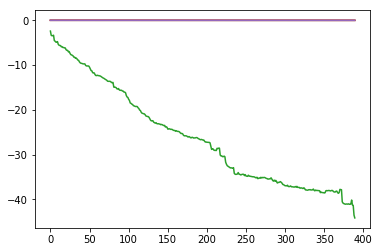

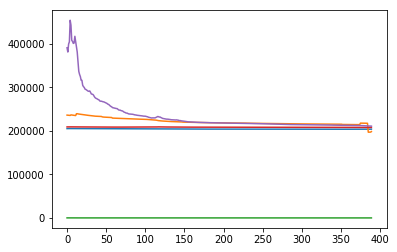

In [46]:
plt.figure()
plt.plot(noise.T)

plt.figure()
plt.plot(p_zero.T)

# This looks like crap